# An introduction to Surjectors

This introductory notebook illustrates the usage of the basic functionality of `Surjectors` such as

- using [Haiku](https://github.com/google-deepmind/dm-haiku), [Distrax](https://github.com/google-deepmind/distrax) and [Optax](https://github.com/google-deepmind/optax),
- defining transformed distributions, 
- and training a normalizing flow.

At its core, `Surjector` uses Haiku to compose functions with trainable parameters, such as neural networks, and Distrax to compute probability densities and sample random variables. Hence using `Surjectors` also requires some knowledge of these two.
Below we illustrate how to use Haiku's core functionality to build pure functions and how to build normalizing flows for density estimation. You can find an interactive version here:

Interactive online version:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dirmeier/surjectors/blob/main/docs/notebooks/introduction.ipynb)

In [1]:
from collections import namedtuple

import distrax
import haiku as hk
import jax
import numpy as np
import optax
from jax import jit
from jax import numpy as jnp
from jax import random as jr

%matplotlib inline
import matplotlib.pyplot as plt

from surjectors import Chain, MaskedCoupling, Slice, TransformedDistribution
from surjectors.nn import make_mlp
from surjectors.util import as_batch_iterator, make_alternating_binary_mask

## How to construct a Haiku module

We begin by demonstrating how to construct a normalizing flow using Haiku modules. A more torough introduction to Haiku can be found [here](https://dm-haiku.readthedocs.io/en/latest/). We start with some code, before we explain what it does.

In [2]:
def make_flow(n_dimensions):
    def flow(**kwargs):
        def decoder_fn(n_dim):
            def _fn(z):
                params = make_mlp([4, n_dim * 2])(z)
                means, log_scales = jnp.split(params, 2, -1)
                return distrax.Independent(
                    distrax.Normal(means, jnp.exp(log_scales)),
                    reinterpreted_batch_ndims=1,
                )

            return _fn

        transform = Slice(n_dimensions // 2, decoder_fn(n_dimensions // 2))
        base_distribution = distrax.Independent(
            distrax.Normal(
                jnp.zeros(n_dimensions // 2), jnp.ones(n_dimensions // 2)
            ),
            reinterpreted_batch_ndims=1,
        )
        pushforward = TransformedDistribution(base_distribution, transform)
        return pushforward(**kwargs)

    td = hk.transform(flow)
    return td

This example uses a `Slice` surjector to reduce the dimensionality of some data by a factor of two: ` Slice(n_dimensions // 2, decoder_fn(n_dimensions // 2))`.

Constructing a Haiku module needs to be done within a `hk.transform` block. This can either be done by providing a function like here and an object. In our case we are using `hk.transform` on `pushforward(**kwargs)` which calls
the `__call__` method of `TransformedDistribution`. Since we are generally interested to use *all* functions of a `TransformedDistribution`, e.g., `sample` and `log_prob`, the `__call__` function is implemented to dispatch on a method based on what is provided in `**kwargs`. More on that later (see the Section below).

We can now initialize the module. With Haiku, we first initialize trainable parameters using `fn.init`.

In [3]:
rng_key_seq = hk.PRNGSequence(0)

n, p = 1000, 10
y = jr.normal(next(rng_key_seq), (n, p))

fn = make_flow(p)
params = fn.init(next(rng_key_seq), method="log_prob", y=y)
params

{'mlp/~/linear_0': {'w': Array([[ 0.00938151,  0.00138335,  0.0027178 ,  0.00052393],
         [ 0.00773658,  0.00142679, -0.00033992,  0.00513109],
         [ 0.01221598,  0.01620722,  0.009937  , -0.00184268],
         [-0.00059485,  0.00240193,  0.01265547, -0.00374089],
         [-0.0061826 , -0.01318036, -0.00686558, -0.01773127]],      dtype=float32),
  'b': Array([0., 0., 0., 0.], dtype=float32)},
 'mlp/~/linear_1': {'w': Array([[-0.01119876, -0.01138027,  0.0113112 , -0.01312024,  0.00154802,
           0.00816533, -0.00145846,  0.01340849, -0.01006911,  0.01952732],
         [ 0.01008801,  0.00135307, -0.0115126 , -0.00349136, -0.00175548,
           0.01259692, -0.01788977, -0.01747455, -0.00335201,  0.00770757],
         [-0.0051812 , -0.01671031, -0.01600558,  0.00488472,  0.00310151,
           0.01437935,  0.01761029, -0.00858634,  0.00084632,  0.01145467],
         [ 0.0065305 , -0.00679018, -0.00247612,  0.00194623, -0.00034392,
           0.01276916, -0.00199806, -0.00

The only trainable paramaters that are flow defines are the weights of the MLP. The MLP is used to compute the conditional probability density inside the `decoder_fn` function. 
The `Slice` surjector itself doesn't have parameters. We can now test the flow. Let's sample some data first.

In [4]:
samples = fn.apply(
    params, next(rng_key_seq), method="sample", sample_shape=(2,)
)
samples

Array([[-0.41818574, -0.9990921 , -0.4571009 ,  0.49184   , -1.8751731 ,
         0.35141623,  1.0676235 ,  0.19257896, -1.9419447 , -0.34831345],
       [ 0.9423704 ,  1.0199391 ,  0.45825312,  0.27037895, -0.62269354,
         0.81362796,  1.8094251 ,  0.64449644, -0.8468613 , -1.4004126 ]],      dtype=float32)

As mentioned above, in order to dispatch to a method, we just provide a keyword argument. In this case this is `method='sample'`. Computing the log probability of the data can be done by changing the method argument to `log_prob`.

In [5]:
fn.apply(params, next(rng_key_seq), method="log_prob", y=samples)

Array([-14.356607, -14.004238], dtype=float32)

## Working with Haiku modules

Haiku's `hk.transform` transforms a function or object into a pure function `fn` that can be used with `jax.vmap` or `jax.pmap` and which can be called using `fn.apply`. When calling `fn.apply` the `__call__` method of the original object is called. Unfortunately, this means that there is only one entry point to an object (i.e., `__call__`) and there is (afaict) no direct way to call member functions of a class. As a remedy, all classes that `Surjector` exposes implement a `__call__` that can be used to call all other functions.

What does that mean exactly? Consider again the transformed distribution object from above:

```
TransformedDistribution(base_distribution, transform)
```

When transforming this object

```
fn = hk.transform(lambda x: TransformedDistribution(base_distribution, transform)(y))
```

and then calling its pure function transformation

```
fn.apply(None, None, y)
```

Haiku calls `TransformedDistribution.__call__(y)`. In order to have access to all other member functions, which in this case are

- `sample`
- `log_prob`
- `sample_and_log_prob`
- `inverse_and_log_prob`


we implemented `__call__` with the following signature and method body:

```
def __call__(self, method, **kwargs):       
    return getattr(self, method)(**kwargs)
```

This allows dispatching to every member function a class has. Concretely, we would call 

```
fn.apply(params, rng_key, method="log_prob", y=y)
```

when we want to call `TransformedDistribution.log_prob(y)`.

**Information of which methods classes implement can be found in the API documentation.**

## How to construct `TransformedDistribution` objects

The `TransformedDistribution` class takes a base distribution and a transformation that maps a sample from the base distribution to the distribution that is induced by the transformation. It's important to note that the dimensionality of the base distribution needs to have the same cardinality as the result of applying a transform on a data point. For instance, consider the transform below where we again use a `Slice` surjector.

In [6]:
def make_transform(n_dimensions):
    def transform(**kwargs):
        def decoder_fn(n_dim):
            def fn(z):
                params = make_mlp([4, n_dim * 2])(z)
                means, log_scales = jnp.split(params, 2, -1)
                return distrax.Independent(
                    distrax.Normal(means, jnp.exp(log_scales)),
                    reinterpreted_batch_ndims=1,
                )

            return fn

        slic = Slice(n_dimensions // 2, decoder_fn(n_dimensions // 2))
        return slic(**kwargs)

    td = hk.transform(transform)
    return td

The transform above defines a simple parameterized transformation and not a pushforward measure (in which we are typically interested in when working with flows).
Depending on the `method` argument, it reduces the dimensionality of the input or increases it.

In [7]:
rng_key_seq = hk.PRNGSequence(0)

n, p = 1000, 10
y = jr.normal(next(rng_key_seq), (n, p))

transform = make_transform(p)
params = transform.init(next(rng_key_seq), method="inverse", y=y)

z = transform.apply(params, next(rng_key_seq), method="inverse", y=y)
z.shape

(1000, 5)

The *forward* transformation takes as an argument a variable $Z$ from the latent space:

In [8]:
y_hat = transform.apply(params, next(rng_key_seq), method="forward", z=z)
y_hat.shape

(1000, 10)

When defining a normalizing flow, it assumes that the transformation is the **inverse** mapping, i.e., the mapping from data to latent space. Hence the transform $f$ is defined $f: \mathcal{Y} \rightarrow \mathcal{Z}$ (technically this means that
`TransformedDistribution` defines the pullback).

With this, we can now define a `TransformedDistribution`. A transformed distribution is defined by 

- a base measure `base_distribution`,
- and a transform `transform`.

For instance, again as a Haiku module:

In [9]:
def make_flow(n_dimensions):
    def flow(**kwargs):
        def decoder_fn(n_dim):
            def fn(z):
                params = make_mlp([64, 64, n_dim * 2])(z)
                means, log_scales = jnp.split(params, 2, -1)
                return distrax.Independent(
                    distrax.Normal(means, jnp.exp(log_scales)),
                    reinterpreted_batch_ndims=1,
                )

            return fn

        transform = Slice(n_dimensions // 2, decoder_fn(n_dimensions // 2))
        base_distribution = distrax.Independent(
            distrax.Normal(
                jnp.zeros(n_dimensions // 2), jnp.ones(n_dimensions // 2)
            ),
            reinterpreted_batch_ndims=1,
        )
        pushforward = TransformedDistribution(base_distribution, transform)
        return pushforward(**kwargs)

    td = hk.transform(flow)
    return td

Initialize and apply the flow:

In [10]:
rng_key_seq = hk.PRNGSequence(0)

n, p = 1000, 100
y = jr.normal(next(rng_key_seq), (n, p))

fn = make_flow(p)
params = fn.init(next(rng_key_seq), method="log_prob", y=y)

lps = fn.apply(params, next(rng_key_seq), method="log_prob", y=y)
samples = fn.apply(
    params, next(rng_key_seq), method="sample", sample_shape=(10,)
)

## Training a normalizing flow

We are now set up to actually train the parameters of the flow which we do using the gradient-transformation library Optax. The code excerpt below can be used for training any flow in `Surjectors` (with some minor modifications).

In [11]:
def train(rng_key, data, model, n_iter=1000):
    # convert the data set to an iterator
    batch_key, rng_key = jr.split(rng_key)
    train_iter = as_batch_iterator(batch_key, data, 100, True)

    # initialize the model
    init_key, rng_key = jr.split(rng_key)
    params = model.init(init_key, method="log_prob", **train_iter(0))

    # create an optimizer
    optimizer = optax.adam(1e-4)
    state = optimizer.init(params)

    @jit
    # gradient step
    def step(params, state, **batch):
        def loss_fn(params):
            lp = model.apply(params, None, method="log_prob", **batch)
            return -jnp.mean(lp)

        loss, grads = jax.value_and_grad(loss_fn)(params)
        updates, new_state = optimizer.update(grads, state, params)
        new_params = optax.apply_updates(params, updates)
        return loss, new_params, new_state

    losses = np.zeros(n_iter)
    # training loop
    for i in range(n_iter):
        train_loss = 0.0
        # iterate over batches
        for j in range(train_iter.num_batches):
            batch = train_iter(j)
            batch_loss, params, state = step(params, state, **batch)
            train_loss += batch_loss
        losses[i] = train_loss

    return params, losses

Let's test this to train a flow on a simple two-dimensional data set.

In [12]:
n, p = 1000, 2
z = jr.normal(next(rng_key_seq), (n, p))
y = jnp.vstack([jnp.abs(z[:, 0]), jax.nn.sigmoid(z[:, 1])]).T

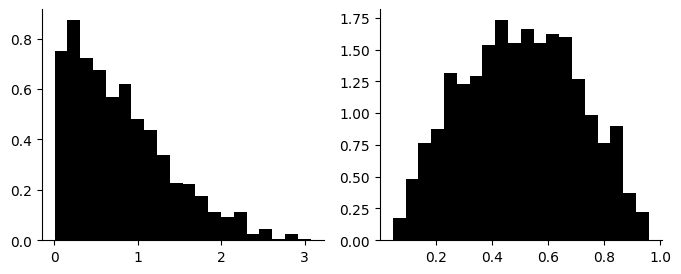

In [13]:
_, axes = plt.subplots(figsize=(8, 3), ncols=2)
for i, ax in enumerate(axes):
    ax.hist(y[:, i], color="black", density=True, bins=20)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
plt.show()

We use a masked coupling bijector with affine transformations. Specifically, we use five masked coupling layers that we concatenate using the `Chain` operator.

In [14]:
def make_flow(n_dimensions):
    def flow(**kwargs):
        def bijector_fn(params):
            means, log_scales = jnp.split(params, 2, -1)
            return distrax.ScalarAffine(means, jnp.exp(log_scales))

        layers = []
        for i in range(5):
            layer = MaskedCoupling(
                mask=make_alternating_binary_mask(n_dimensions, i % 2 == 0),
                bijector_fn=bijector_fn,
                conditioner=make_mlp([32, 32, n_dimensions * 2]),
            )
            layers.append(layer)

        transform = Chain(layers)
        base_distribution = distrax.Independent(
            distrax.Normal(jnp.zeros(n_dimensions), jnp.ones(n_dimensions)),
            reinterpreted_batch_ndims=1,
        )
        pushforward = TransformedDistribution(base_distribution, transform)

        return pushforward(**kwargs)

    td = hk.transform(flow)
    return td

To train the flow we need to provide a data argument for `as_batch_iterator` which has to be a named tuple. If the tuple has one element, called `y`, an unconditional flow is trained. If a tuple with two elements, called `y` and `x`, is provided, a conditional flow is trained.

In [15]:
fn = make_flow(p)
data = namedtuple("named_dataset", "y")(y)
params, losses = train(next(rng_key_seq), data, fn)

That's it. Let's draw some sampels.

In [16]:
samples = fn.apply(
    params, next(rng_key_seq), method="sample", sample_shape=(1000,)
)

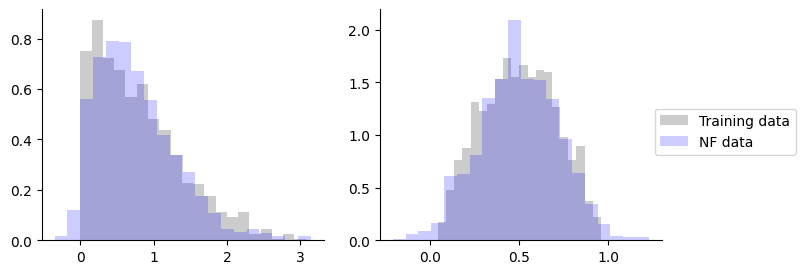

In [17]:
_, axes = plt.subplots(figsize=(8, 3), ncols=2)
for i, ax in enumerate(axes):
    ax.hist(
        y[:, i],
        color="black",
        density=True,
        bins=20,
        alpha=0.2,
        label="Training data",
    )
    ax.hist(
        samples[:, i],
        color="blue",
        density=True,
        bins=20,
        alpha=0.2,
        label="NF data",
    )
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
plt.legend(loc="upper right", bbox_to_anchor=(1.5, 0.6))
plt.show()

## Session info

In [18]:
import session_info

session_info.show(html=False)

-----
distrax             0.1.5
haiku               0.0.11
jax                 0.4.23
jaxlib              0.4.23
matplotlib          3.8.2
numpy               1.26.3
optax               0.1.8
session_info        1.0.0
surjectors          0.3.0
-----
IPython             8.21.0
jupyter_client      8.6.0
jupyter_core        5.7.1
jupyterlab          4.0.12
notebook            7.0.7
-----
Python 3.11.7 | packaged by conda-forge | (main, Dec 23 2023, 14:38:07) [Clang 16.0.6 ]
macOS-13.0.1-arm64-arm-64bit
-----
Session information updated at 2024-02-01 17:03


## References

[1] Klein, Samuel, et al. "Funnels: Exact maximum likelihood with dimensionality reduction". Workshop on Bayesian Deep Learning, Advances in Neural Information Processing Systems, 2021.

[2] Durkan, Conor, et al. "Neural Spline Flows". Advances in Neural Information Processing Systems, 2019.

[3] Papamakarios, George, et al. "Masked Autoregressive Flow for Density Estimation". Advances in Neural Information Processing Systems, 2017.